# Predicting tags on StackOverflow

In [1]:
import sys
from ast import literal_eval
import pandas as pd
import numpy as np

sys.path.append("..")
from common.download_utils import download_week1_resources

download_week1_resources()

File data/train.tsv is already downloaded.
File data/validation.tsv is already downloaded.
File data/test.tsv is already downloaded.
File data/text_prepare_tests.tsv is already downloaded.


### Text preprocessing

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bronwynbiro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [4]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values

### Text and data preprocessing

In [5]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text)
    text = re.sub(BAD_SYMBOLS_RE, "", text)
    text = [word for word in text.split() if word not in STOPWORDS]
    return " ".join(text)

In [6]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [7]:
print(test_text_prepare())

Basic tests are passed.


In [8]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)


In [9]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [10]:
from collections import Counter
tags_counts = {}
words_counts = {}

tag_text = ",".join( [ ",".join(l) for l in  list(train['tags'].values) ]).split(",")
tags_counts = dict(Counter(tag_text))

word_text =  ",".join( X_train).split(",")
words_counts = dict(Counter(word_text))


common_words = ",".join([ tag[0] for tag in list(Counter(words_counts).most_common(3)) ] )
common_tags = ",".join([ word[0] for word in list(Counter(tags_counts).most_common(3)) ] )
print(common_tags)
print(common_words)

javascript,c#,java
mean,difference,conversion failed converting date time character string


In [11]:
most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

### Transforming text to a vector

1. Find N most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to N.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
DICT_SIZE = 5000
WORDS_TO_INDEX = {word:index for index, word in enumerate(dict(Counter(words_counts).most_common(DICT_SIZE)).keys())}
INDEX_TO_WORDS = {v: k for k, v in WORDS_TO_INDEX.items()}

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    
    for word in text.split():
      if word in words_to_index:
        index = words_to_index[word]
        result_vector[index]+=1
    return result_vector

In [13]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

test_my_bag_of_words()

'Basic tests are passed.'

Now, convert all samples to the bag of words model.

In [14]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)

X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [15]:
row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = np.count_nonzero(row) 

### TF-IDF

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(token_pattern='(\S+)', ngram_range=(1, 2), max_df=0.9, min_df=5)
    all=X_train.copy()
    all.extend(X_val)
    all.extend(X_test)
    tfidf_vectorizer =  tfidf_vectorizer.fit(all)
    return tfidf_vectorizer.transform(X_train), tfidf_vectorizer.transform(X_val), tfidf_vectorizer.transform(X_test), tfidf_vectorizer.vocabulary_

In [17]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}

tfidf_vocab["c++"]
tfidf_vocab["c#"]
tfidf_vocab["java"]

12178

### MultiLabel classifier

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

In [20]:
def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    classifier = OneVsRestClassifier(LogisticRegression())
    classifier.fit(X_train, y_train)
    return classifier

In [21]:
classifier_mybag = train_classifier(X_train_mybag, y_train)
classifier_tfidf = train_classifier(X_train_tfidf, y_train)

In [27]:
y_val_predicted_labels_mybag  = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)

In [28]:
y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_tfidf)
y_val_inversed = mlb.inverse_transform(y_val)
for i in range(3):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))

Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails




### Evaluation

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [32]:
def print_evaluation_scores(y_val, predicted):
    
    print("Accuracy: {}\n".format(accuracy_score(y_val, predicted)))

    print("Macro average_precision_score={}\n".format(average_precision_score(y_val, predicted, average = "macro")))
    print("Micro average_precision_score={}\n".format(average_precision_score(y_val, predicted, average = "micro")))
    print("Weighted average_precision_score={}\n".format( average_precision_score(y_val, predicted, average = "weighted")))

    print("Macro f1_score={}\n".format(f1_score(y_val, predicted, average = "macro")))
    print("Micro f1_score={}\n".format(f1_score(y_val, predicted, average = "micro")))
    print("Weighted f1_score={}\n".format(f1_score(y_val, predicted, average = "weighted")))
          

In [33]:
print('Bag-of-words')
print_evaluation_scores(y_val, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val, y_val_predicted_labels_tfidf)

Bag-of-words
Accuracy: 0.038933333333333334

Macro average_precision_score=0.02381912965286388

Micro average_precision_score=0.06692865730615366

Weighted average_precision_score=0.12336253767239852

Macro f1_score=0.008673209440861217



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Micro f1_score=0.09404490725675235

Weighted f1_score=0.07849754131153452

Tfidf
Accuracy: 0.3278

Macro average_precision_score=0.28955110482681157

Micro average_precision_score=0.4499538795009354

Weighted average_precision_score=0.47744973107377764

Macro f1_score=0.4288555396534797

Micro f1_score=0.6333710181552171

Weighted f1_score=0.604114699628448



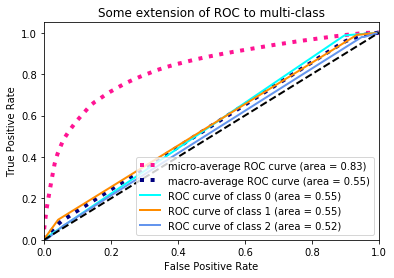

In [34]:
from metrics import roc_auc
%matplotlib inline
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

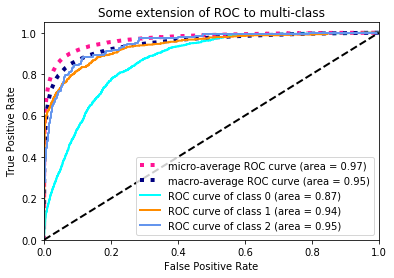

In [35]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)